In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
from matplotlib.patches import Circle

from model import vdm_model, networks
from utils import compute_pk
from data import constants

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })

In [3]:
def load_model(dataset = 'Astrid',
        cropsize = 256,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = True,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,cropsize,cropsize),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    ckpt = 'ckpt_path'

    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [4]:
dataset = 'Astrid'

In [5]:
# Load data
mass_mstar = np.load(f'/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mstar_{dataset}_CV_z=0.00.npy')
mass_cdm = np.load(f'/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mcdm_{dataset}_CV_z=0.00.npy')
mass_mstar = np.log10(mass_mstar+1)
mass_cdm = np.log10(mass_cdm)

mean_input = constants.norms[dataset][0]
std_input = constants.norms[dataset][1]
mean_target = constants.norms[dataset][2]
std_target = constants.norms[dataset][3]

mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [6]:
# Generate image fields
conditioning = mass_mstar_normed[0].to(device)
x = mass_cdm_normed[0].to(device)
vdm = load_model()
sample = vdm.draw_samples(
                conditioning=conditioning,
                batch_size=len(x),
                n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
sample = sample * std_target + mean_target

In [7]:
colors = ['#935083', '#FB8B6F', '#FFBE62', '#D16580','#00C89E']

In [8]:
halos = {
    (50, 89) : 5,
    (150, 146) : 4,
    (8, 238) : 5,
    (60, 37) : 4,
    (180, 92) : 7,
}

In [9]:
X, Y = np.ogrid[:256, :256]
true_masses = []
masks = []
for center, radius in halos.items():
    distance = np.sqrt((X-center[0])**2+(Y-center[1])**2)
    cdm_mass = mass_cdm[0].squeeze()
    mask = distance <= radius
    masks.append(mask)
    masked = cdm_mass.copy()
    masked[~mask] = 0
    true_masses.append(np.sum(10 ** masked))

In [10]:
def generate_samples(vdm, conditioning, batch_size=10, n=10):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2])

    maps = [] # n tensors of shape ([batch_size, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [11]:
# Get total masses
vdm = load_model(dataset=dataset)
generated_masses = []
generated_normed = torch.vstack(
    generate_samples(
        vdm,
        conditioning=mass_mstar_normed[0].to(device), 
        batch_size=50, 
        n=20,
    )
)
generated = generated_normed * std_target + mean_target
for mask in masks:
    generated_mass = []
    for sample in generated:
        masked = sample.squeeze().detach().clone()
        masked[~mask] = 0
        generated_mass.append(torch.sum(10**masked).item())
    generated_masses.append(np.array(generated_mass))

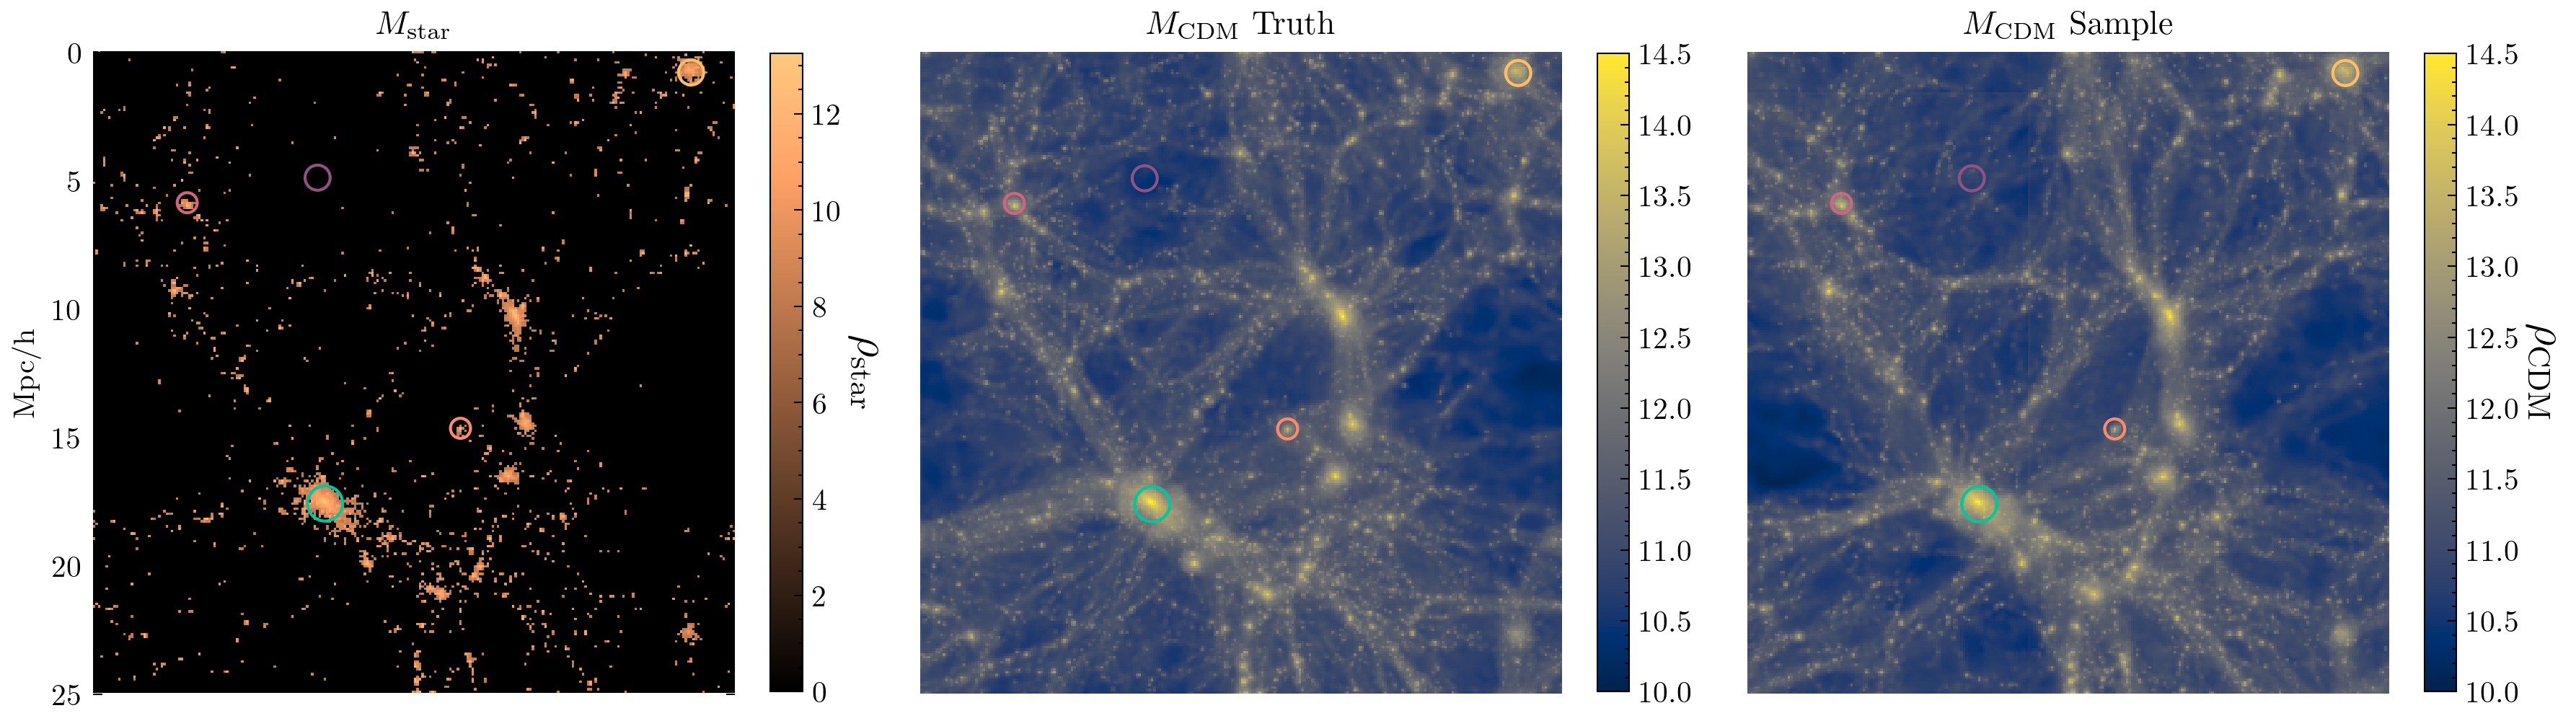

In [43]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
img = axes[0].imshow(mass_mstar[0].squeeze(), cmap='copper')
cbar = fig.colorbar(img, ax=axes[0], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\rho_{\mathrm{star}}$", rotation=270, fontsize=15)
img = axes[1].imshow(mass_cdm[0].squeeze(), cmap='cividis',vmin=10,vmax=14.5)
fig.colorbar(img, ax=axes[1], fraction=0.045)
img = axes[2].imshow(generated[40].cpu().squeeze(), cmap='cividis',vmin=10,vmax=14.5)
cbar = fig.colorbar(img, ax=axes[2], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\rho_{\mathrm{CDM}}$', rotation=270, fontsize=15)

for i, (center, radius) in enumerate(halos.items()):
    axes[0].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))
    axes[1].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))
    axes[2].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))

axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks([])
axes[0].set_yticks([0., 51.2, 102.4, 153.6, 204.8, 256.], labels=["0", "5", "10", "15", "20", "25"])
axes[0].set_ylabel("Mpc/h")        
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title(r"$M_{\mathrm{star}}$")
axes[1].set_title(r"$M_{\mathrm{CDM}}$ Truth")
axes[2].set_title(r"$M_{\mathrm{CDM}}$ Sample")
plt.tight_layout()

Text(0.5, 1.0, 'Probability distribution of the halo mass')

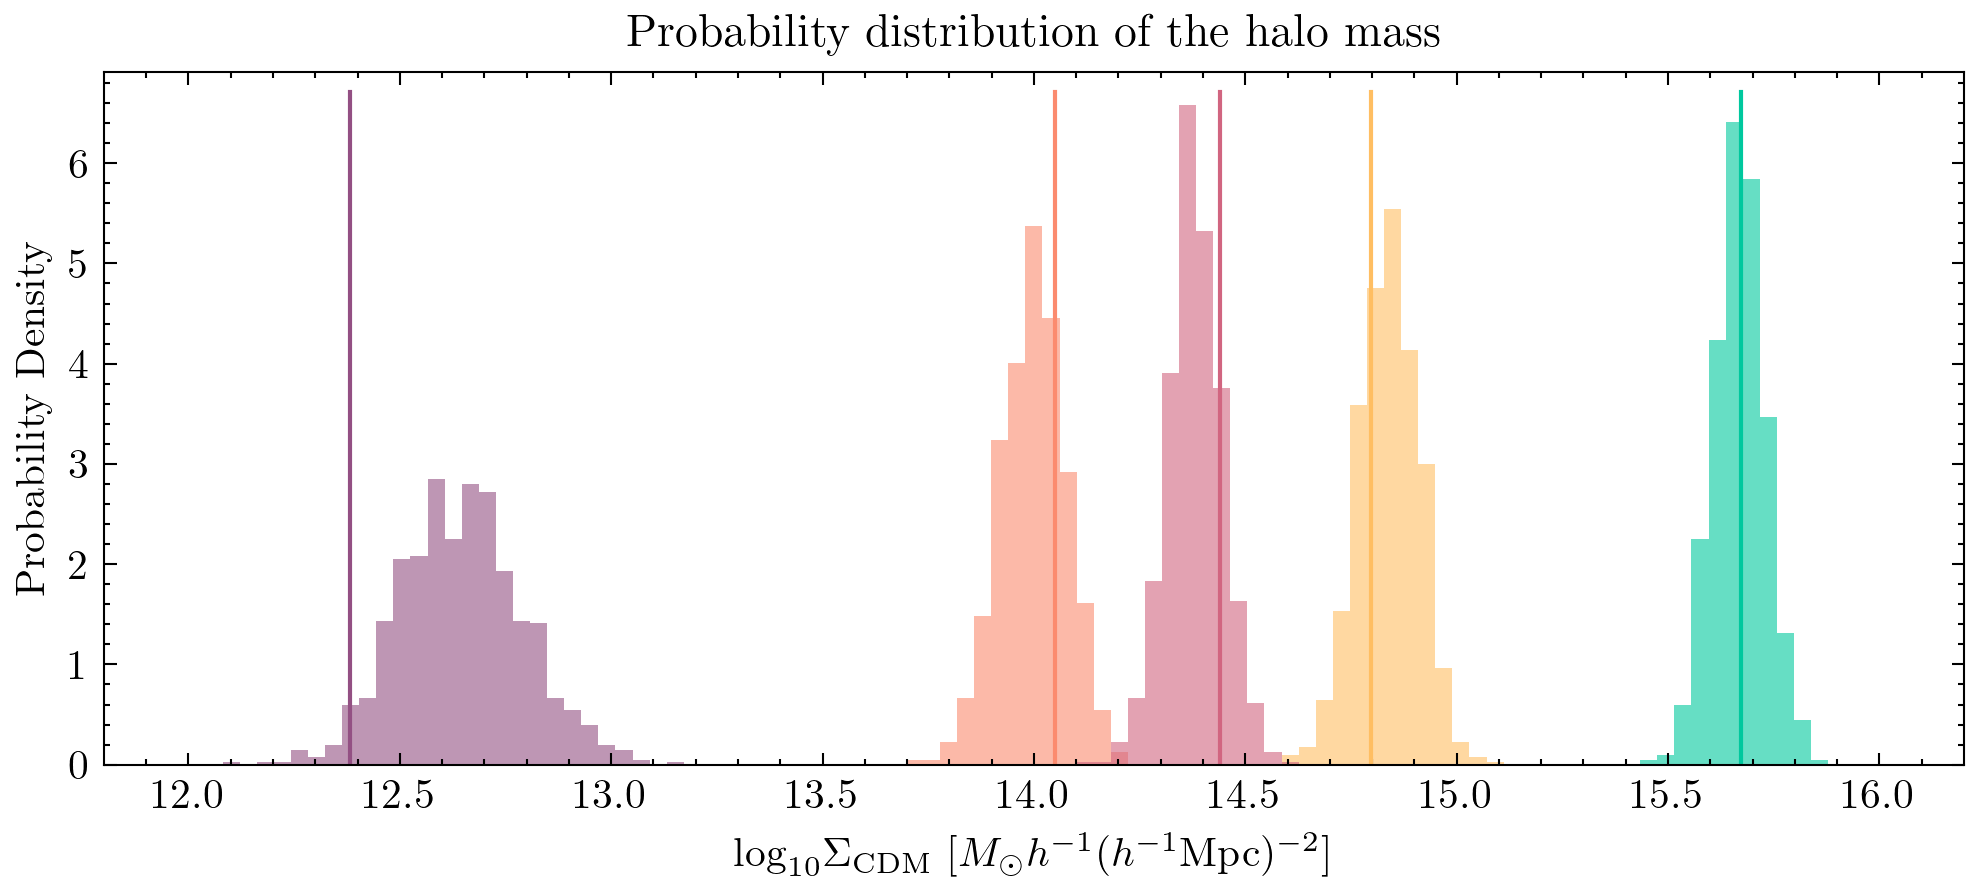

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
n_bins = 25
mbin = np.linspace(12,16,100)
for i in range(len(generated_masses)):
  ax.hist(np.log10(generated_masses[i]), bins=mbin, color=colors[i], alpha=0.6, histtype='stepfilled', density=True,
            )
  ax.axvline(np.log10(true_masses[i]), 0, 0.97, color=colors[i])

ax.set_xlabel(r'$\mathrm{log}_{10} \Sigma_{\mathrm{CDM}}$ ' + '$[M_{\odot} h^{-1} ( h^{-1} \mathrm{Mpc})^{-2}]$')
ax.set_ylabel('Probability Density')
ax.set_title('Probability distribution of the halo mass')